In [ ]:
# x1, y1, w, h, blur, expression, illumination, invalid, occlusion, pose

In [3]:
import os
import json
import cv2
from matplotlib import pyplot as plt
from dataset import read_wider_meta

from utils import letterbox_pad

### Calculate and write meta

In [2]:
data_root = './data/'

# calculate
# train_meta = read_wider_meta(data_root, phase='train')
# val_meta = read_wider_meta(data_root, phase='val')
# test_meta = read_wider_meta(data_root, phase='test')

# write
# with open('./data/train.json', 'w') as fwrite:
#     json.dump(train_meta, fwrite)
    
# with open('./data/val.json', 'w') as fwrite:
#     json.dump(val_meta, fwrite)

# with open('./data/test.json', 'w') as fwrite:
#     json.dump(test_meta, fwrite)

### Read meta

In [4]:
with open('./data/train.json', 'r') as fread:
    train_meta = json.load(fread)
    
with open('./data/val.json', 'r') as fread:
    val_meta = json.load(fread)
    
with open('./data/test.json', 'r') as fread:
    test_meta = json.load(fread)

In [60]:
val_meta['1131']

{'full_file_path': './data/WIDER_val/images/23--Shoppers/23_Shoppers_Shoppers_23_259.jpg',
 'size_HW': [787, 1024],
 'gt_bboxes': [[202, 96, 160, 218, 0, 0, 0, 0, 0, 0],
  [518, 80, 150, 188, 0, 0, 0, 0, 0, 0],
  [762, 66, 140, 196, 0, 0, 0, 0, 0, 0]]}

### Dataset

1385 1385
629 330 751 478
(629, 330) (751, 478)


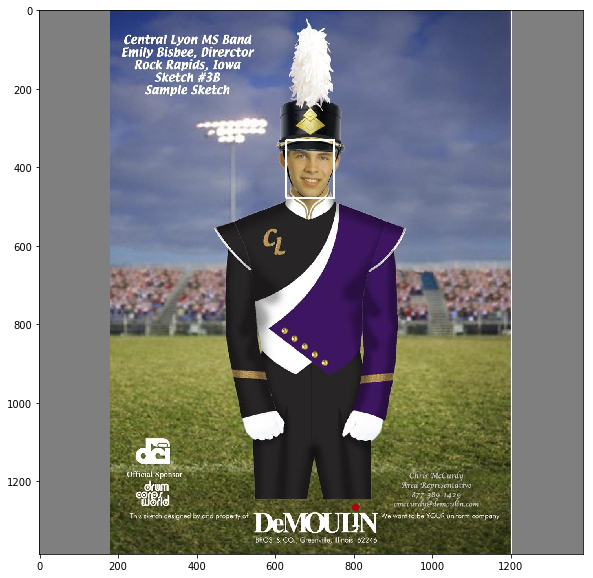

In [5]:
import cv2
from utils import letterbox_pad

img = cv2.imread('./data/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.flip(img, 1)
img, _ = letterbox_pad(img)

# bw, bh are with padding
B, L, cx, cy, bw, bh = 1.0000, 0.0000,  0.4982, 0.2917, 0.0881, 0.1076,

H, W, C = img.shape
print(H, W)
top_left_x = int(cx * W) - int((bw * W)//2)
top_left_y = int(cy * H) - int((bh * H)//2)
bottom_right_x = int(cx * W) + int((bw * W)//2)
bottom_right_y = int(cy * H) + int((bh * H)//2)

print(top_left_x, top_left_y, bottom_right_x, bottom_right_y)

top_left_coords = top_left_x, top_left_y
# top_left_coords = 100, 200
bottom_right_coords = bottom_right_x, bottom_right_y
# bottom_right_coords = 300, 400
print(top_left_coords, bottom_right_coords)
cv2.rectangle(img, top_left_coords, bottom_right_coords, (255, 255, 255), 3)

plt.figure(figsize=(10, 10))
plt.imshow(img)

In [ ]:
10,13,  16,30,  33,23

In [8]:
116 / (416 / 48)

13.384615384615385

In [11]:
for a in [  116,90,  156,198,  373,326, 30,61,  62,45,  59,119, 10,13,  16,30,  33,23,]:
    print(a / (416 / 13), a / (416 / 26), a / (416 / 52))

3.625 7.25 14.5
2.8125 5.625 11.25
4.875 9.75 19.5
6.1875 12.375 24.75
11.65625 23.3125 46.625
10.1875 20.375 40.75
0.9375 1.875 3.75
1.90625 3.8125 7.625
1.9375 3.875 7.75
1.40625 2.8125 5.625
1.84375 3.6875 7.375
3.71875 7.4375 14.875
0.3125 0.625 1.25
0.40625 0.8125 1.625
0.5 1.0 2.0
0.9375 1.875 3.75
1.03125 2.0625 4.125
0.71875 1.4375 2.875


In [ ]:
[ 3.6250,  2.8125],
[ 4.8750,  6.1875],
[11.6562, 10.1875],

[1.8750, 3.8125],
[3.8750, 2.8125],
[3.6875, 7.4375],

[1.2500, 1.6250],
[2.0000, 3.7500],
[4.1250, 2.8750],

In [1]:
import torch
(torch.tensor(2.923).long())

tensor(2)

In [6]:
gxy = torch.arange(10).view(5, 2)
print(gxy)
a, b = gxy.t()
print(a, b)

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])
tensor([0, 2, 4, 6, 8]) tensor([1, 3, 5, 7, 9])
